In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


# Albumentations

- 처리속도가 빠른 augmentation API

- [Albumentations Documentation - Image augmentation for classification](https://albumentations.ai/docs/getting_started/image_augmentation/)

- [albumentations.core.composition.Compose](https://albumentations.ai/docs/api_reference/core/composition/#albumentations.core.composition.Compose)

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

- 위에서 만든 함수를 통해 augmentation 적용해보기

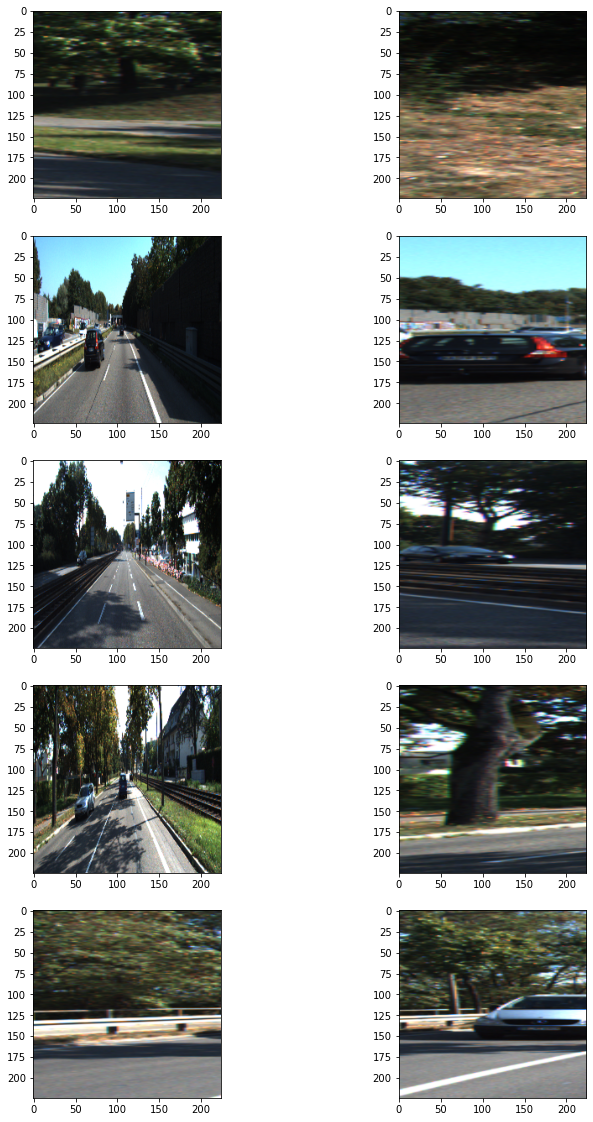

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

- dataset을 generator형태로 구성

- [keras Sequential model API](https://keras.io/ko/models/sequential/)

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

print('슝')

슝


# U-Net 모델 구현

- [keras.layers.Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)

In [6]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [7]:
model = build_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

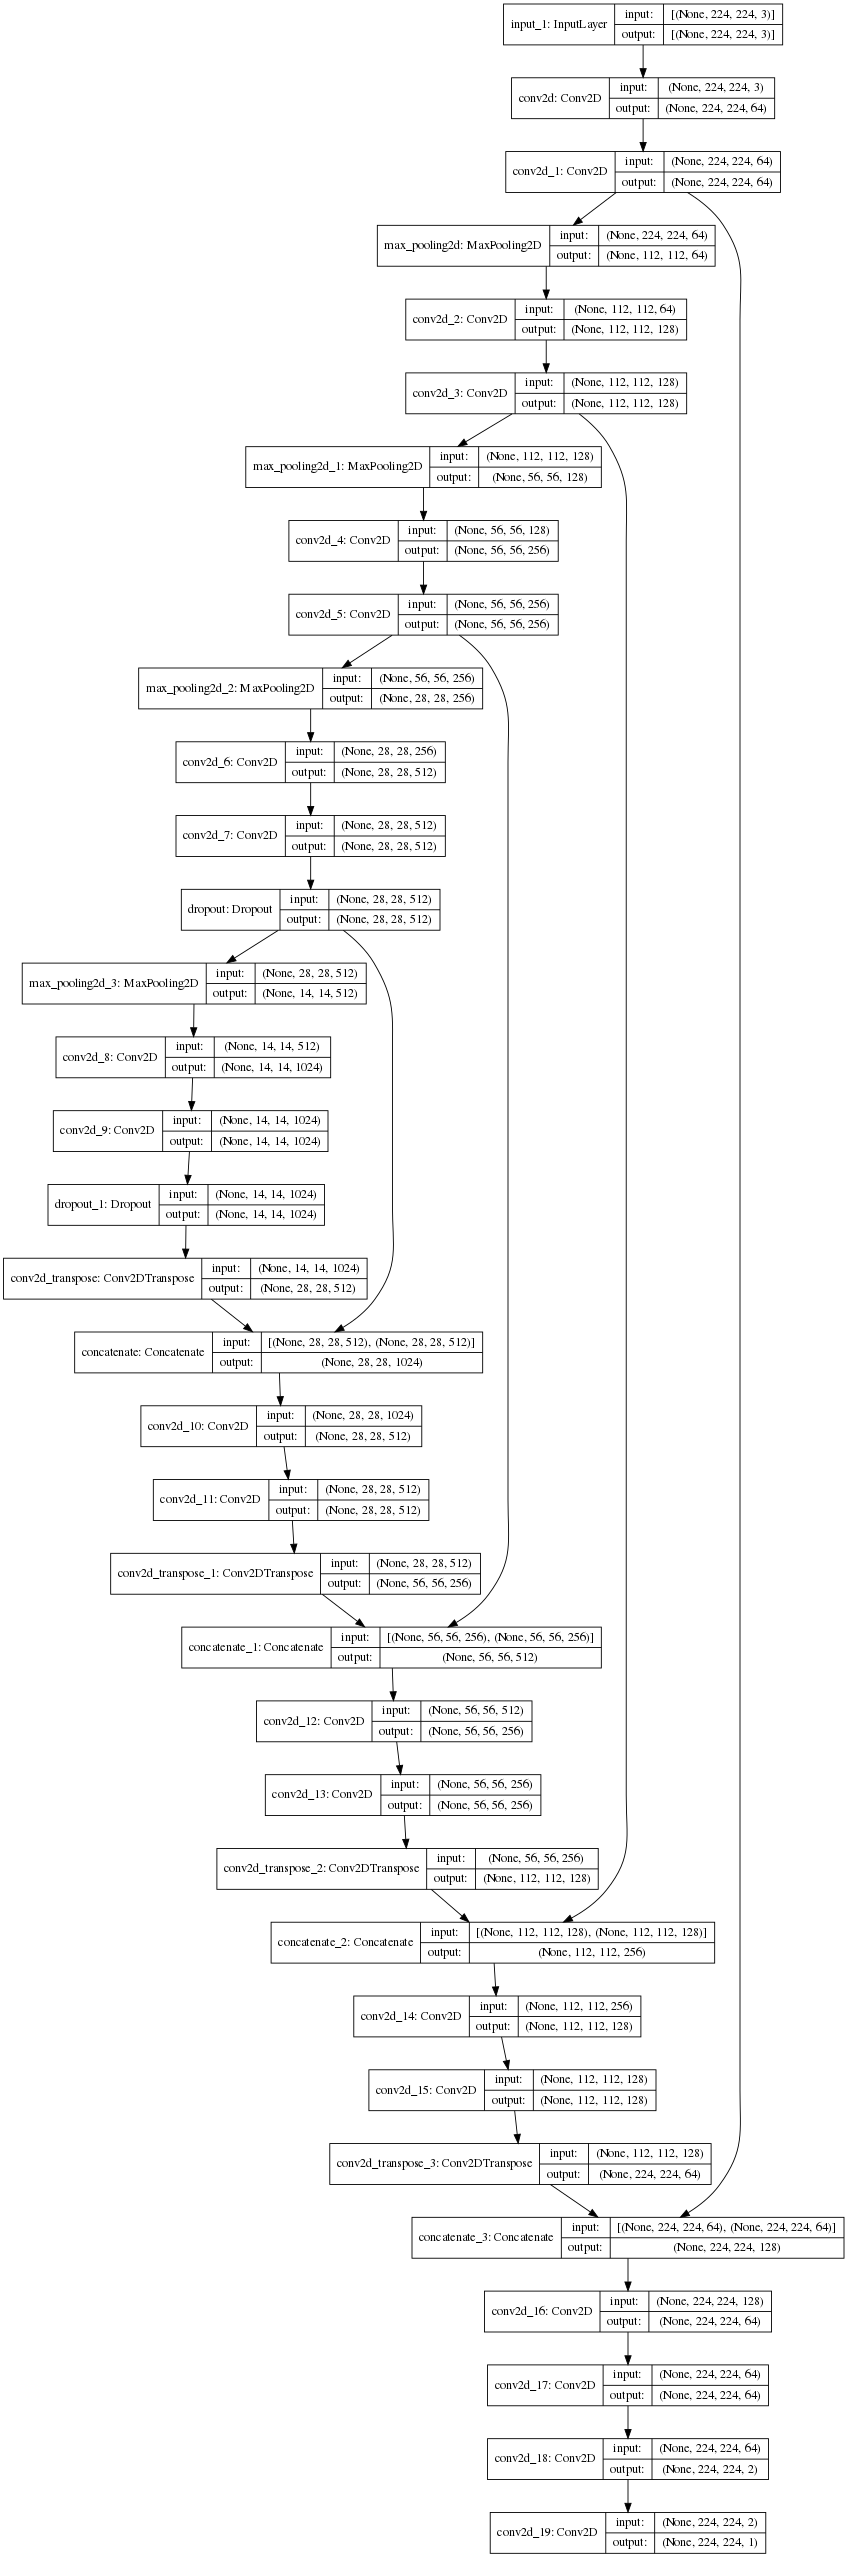

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

- U-Net을 활용했을 뿐이지 논문에나온 모델 아키텍쳐랑은 다르다
  - 원 논문에선 conv연산시 padding을 넣지 않아 feature map사이즈가 줄어들고 concatenation시 사이즈를 맞추기 위해 Contracting Path에서 crop해서 가져온다

# U-Net Training

In [9]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

/home/aiffel-dj45/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 30s 160ms/step - loss: 0.5976 - val_loss: 0.1372
Epoch 2/100
43/43 [==============================] - 6s 148ms/step - loss: 0.1265 - val_loss: 0.1028
Epoch 3/100
43/43 [==============================] - 6s 149ms/step - loss: 0.0975 - val_loss: 0.1242
Epoch 4/100
43/43 [==============================] - 6s 149ms/step - loss: 0.0948 - val_loss: 0.0884
Epoch 5/100
43/43 [==============================] - 6s 149ms/step - loss: 0.0713 - val_loss: 0.0829
Epoch 6/100
43/43 [==============================] - 6s 150ms/step - loss: 0.0644 - val_loss: 0.0949
Epoch 7/100
43/43 [==============================] - 6s 150ms/step - loss: 0.0865 - val_loss: 0.0818
Epoch 8/100
43/43 [==============================] - 6s 150ms/step - loss: 0.0744 - val_loss: 0.0853
Epoch 9/100
43/43 [==============================] - 6s 151ms/step - loss: 0.0724 - val_loss: 0.0767
Epoch 10/100
43/43 [==============================] - 6s 150ms/step - loss: 0.0633 - val_l

43/43 [==============================] - 7s 151ms/step - loss: 0.0339 - val_loss: 0.0681
Epoch 82/100
43/43 [==============================] - 7s 152ms/step - loss: 0.0410 - val_loss: 0.0432
Epoch 83/100
43/43 [==============================] - 7s 151ms/step - loss: 0.0402 - val_loss: 0.0556
Epoch 84/100
43/43 [==============================] - 7s 151ms/step - loss: 0.0369 - val_loss: 0.0680
Epoch 85/100
43/43 [==============================] - 7s 151ms/step - loss: 0.0372 - val_loss: 0.0492
Epoch 86/100
43/43 [==============================] - 7s 151ms/step - loss: 0.0499 - val_loss: 0.0540
Epoch 87/100
43/43 [==============================] - 7s 151ms/step - loss: 0.0387 - val_loss: 0.0519
Epoch 88/100
43/43 [==============================] - 7s 151ms/step - loss: 0.0410 - val_loss: 0.0554
Epoch 89/100
43/43 [==============================] - 7s 151ms/step - loss: 0.0383 - val_loss: 0.0568
Epoch 90/100
43/43 [==============================] - 7s 152ms/step - loss: 0.0352 - val_loss: 

## visualization

In [10]:
'''model_path = dir_path + '/seg_model_unet.h5'
model = tf.keras.models.load_model(model_path)'''

"model_path = dir_path + '/seg_model_unet.h5'\nmodel = tf.keras.models.load_model(model_path)"

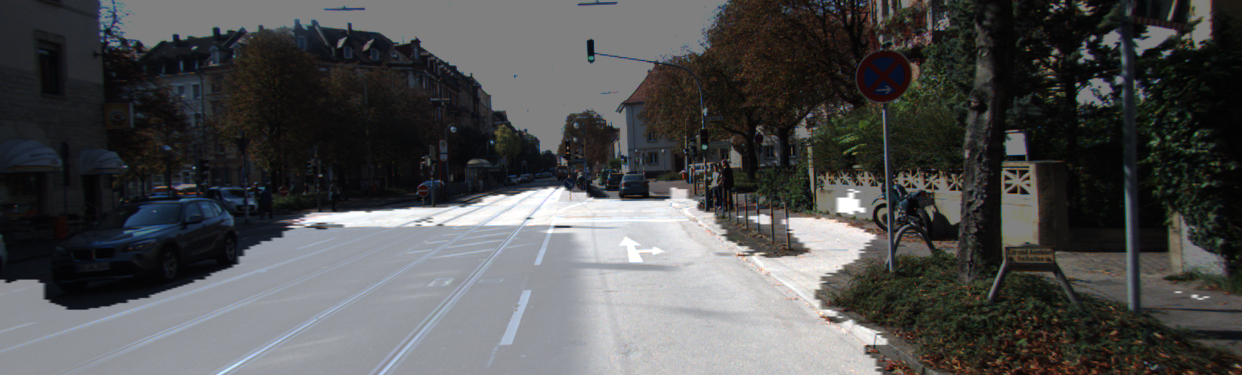

In [11]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    #output.show()
    return output

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

- predict한 road IoU 계산

In [12]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [13]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [14]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.878158


0.8781580493537016

# U-Net++

![](https://images.velog.io/images/kangtae/post/7b1fd119-0004-4da0-89a9-adf549038f8a/UNet++%20Architecture.png)

In [20]:
def build_model_pp(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    x_0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    x_0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name = 'x_0_0')(x_0_0)
    pool1 = MaxPooling2D(pool_size=(2, 2))(x_0_0)
    x_1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    x_1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name = 'x_1_0')(x_1_0)
    pool2 = MaxPooling2D(pool_size=(2, 2))(x_1_0)
    x_2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    x_2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name = 'x_2_0')(x_2_0)
    pool3 = MaxPooling2D(pool_size=(2, 2))(x_2_0)
    x_3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    x_3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name = 'x_3_0')(x_3_0)
    #drop4 = Dropout(0.5)(x_3_0)
    pool4 = MaxPooling2D(pool_size=(2, 2))(x_3_0)

    x_4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    x_4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x_4_0)
    
    
    
    #Expanding Path
    #drop5 = Dropout(0.5)(x_4_0)  # x_4_0
    up_4_0 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x_4_0)
    merge_3_1 = concatenate([x_3_0, up_4_0], axis = 3)  # x_3_1
    x_3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_3_1)
    x_3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x_3_1)
    
    
    up_3_1 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x_3_1)
    # X_2_1
    up_3_0 = Conv2DTranspose(256, 2, activation='relu', padding='same',strides=(2,2), kernel_initializer='he_normal')(x_3_0)
    x_2_1 = concatenate([x_2_0, up_3_0], axis = 3, name = 'x_2_1')
    merge_2_2 = concatenate([x_2_0, x_2_1, up_3_1], axis = 3)
    x_2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_2_2)
    x_2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x_2_2)
    
    up_2_2 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x_2_2)
    # X_1_1
    up_2_0 = Conv2DTranspose(128, 2, activation='relu', padding='same',strides=(2,2), kernel_initializer='he_normal')(x_2_0)
    x_1_1 = concatenate([x_1_0, up_2_0], axis = 3, name = 'x_1_1')
    # X_1_2
    up_2_1 = Conv2DTranspose(128, 2, activation='relu', padding='same',strides=(2,2), kernel_initializer='he_normal')(x_2_1)
    x_1_2 = concatenate([x_1_0, x_1_1, up_2_1], axis = 3, name = 'x_1_2')
    merge_1_3 = concatenate([x_1_0, x_1_1, x_1_2, up_2_2], axis = 3)
    x_1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_1_3)
    x_1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x_1_3)
    
    up_1_3 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x_1_3)
    # X_0_1
    up_1_0 = Conv2DTranspose(64, 2, activation='relu', padding='same',strides=(2,2), kernel_initializer='he_normal')(x_1_0)
    x_0_1 = concatenate([x_0_0, up_1_0], axis = 3, name = 'x_0_1')
    # X_0_2
    up_1_1 = Conv2DTranspose(64, 2, activation='relu', padding='same',strides=(2,2), kernel_initializer='he_normal')(x_1_1)
    x_0_2 = concatenate([x_0_0, x_0_1, up_1_1], axis = 3, name = 'x_0_2')
    # X_0_3
    up_1_2 = Conv2DTranspose(64, 2, activation='relu', padding='same',strides=(2,2), kernel_initializer='he_normal')(x_1_2)
    x_0_3 = concatenate([x_0_0, x_0_1, x_0_2, up_1_2], axis = 3, name = 'x_0_3')
    merge_0_4 = concatenate([x_0_0, x_0_1, x_0_2, x_0_3, up_1_3], axis = 3, name = 'final_concat')
    x_0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge_0_4)
    x_0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x_0_4)  
    x_0_4 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x_0_4)     
    output = Conv2D(1, 1, activation='sigmoid')(x_0_4)

    model = Model(inputs = inputs, outputs = output)
    return model

In [21]:
model_pp = build_model_pp()

In [22]:
model_pp.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
x_0_0 (Conv2D)                  (None, 224, 224, 64) 36928       conv2d_36[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 112, 112, 64) 0           x_0_0[0][0]                      
____________________________________________________________________________________________

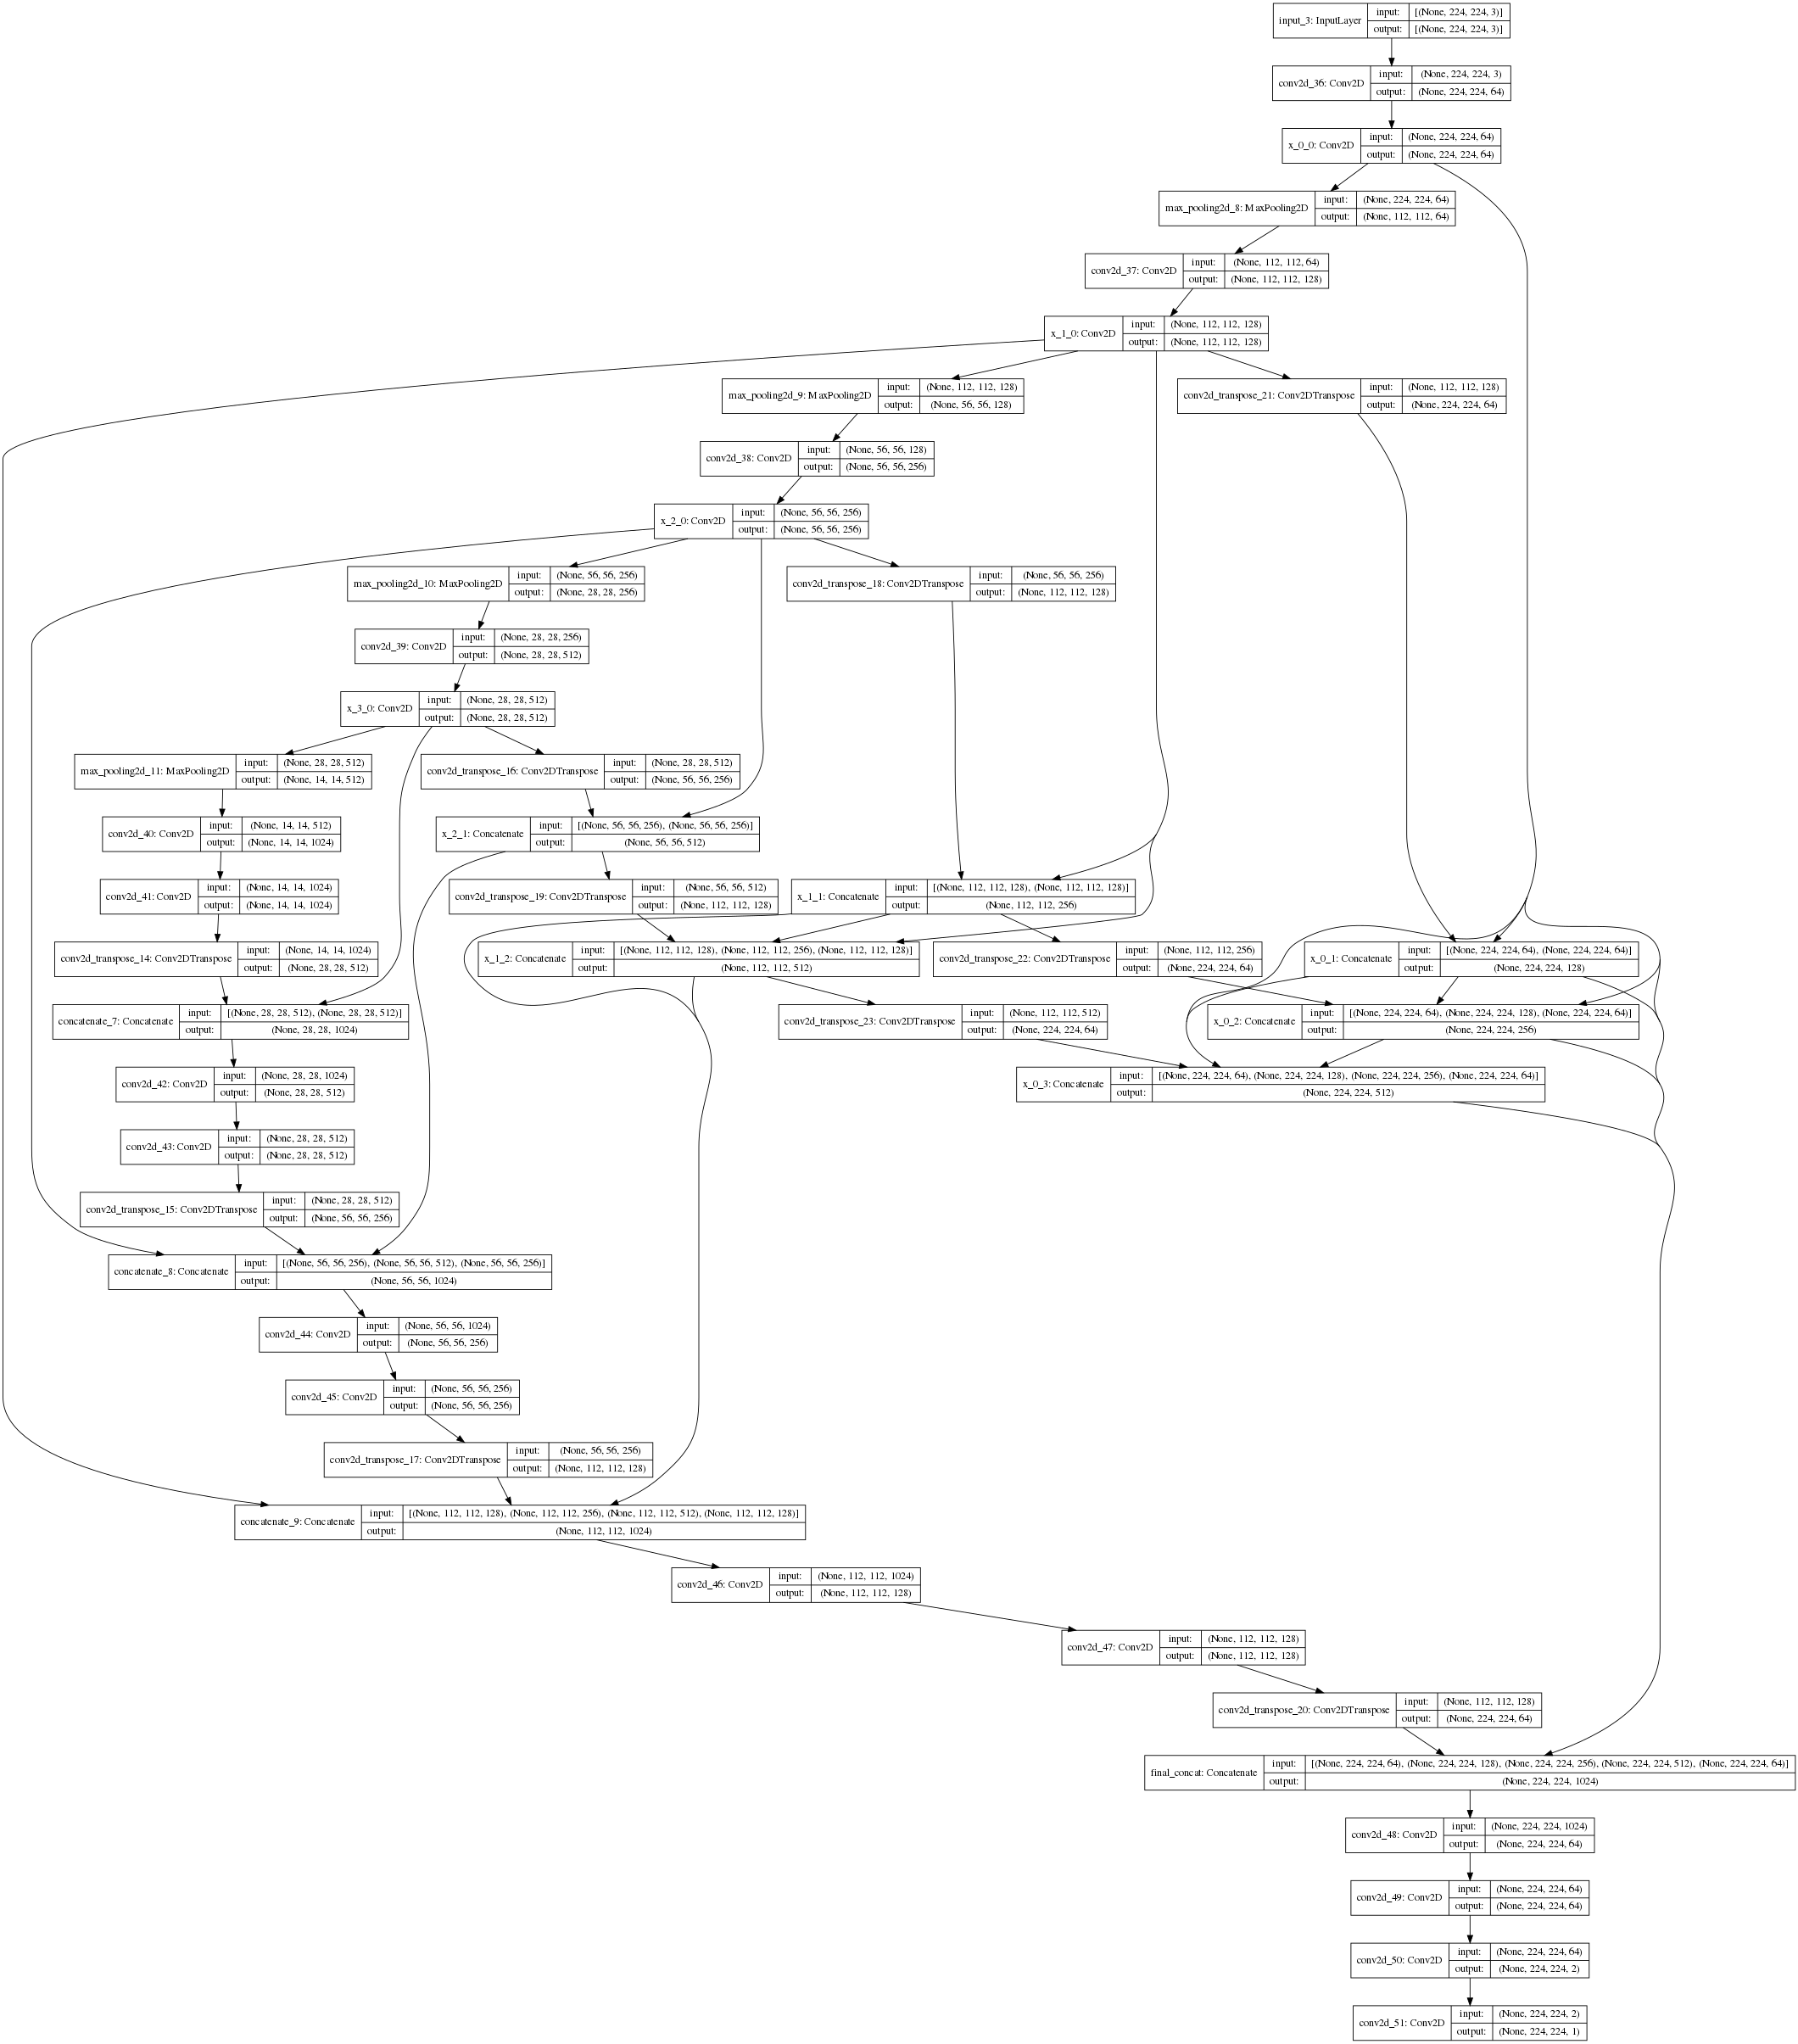

In [23]:
tf.keras.utils.plot_model(model_pp, show_shapes=True, dpi=64)

In [24]:
model_pp.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model_pp.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet_pp.h5'
model_pp.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
43/43 [==============================] - 18s 393ms/step - loss: 0.6495 - val_loss: 0.1318
Epoch 2/100
43/43 [==============================] - 16s 379ms/step - loss: 0.1404 - val_loss: 0.1232
Epoch 3/100
43/43 [==============================] - 16s 381ms/step - loss: 0.1219 - val_loss: 0.1898
Epoch 4/100
43/43 [==============================] - 17s 387ms/step - loss: 0.1366 - val_loss: 0.1079
Epoch 5/100
43/43 [==============================] - 16s 381ms/step - loss: 0.0823 - val_loss: 0.0909
Epoch 6/100
43/43 [==============================] - 16s 383ms/step - loss: 0.0890 - val_loss: 0.0951
Epoch 7/100
43/43 [==============================] - 16s 383ms/step - loss: 0.0792 - val_loss: 0.0782
Epoch 8/100
43/43 [==============================] - 16s 383ms/step - loss: 0.0649 - val_loss: 0.0831
Epoch 9/100
43/43 [==============================] - 16s 383ms/step - loss: 0.0612 - val_loss: 0.0792
Epoch 10/100
43/43 [==============================] - 16s 383ms/step - loss: 0.066

43/43 [==============================] - 17s 384ms/step - loss: 0.0575 - val_loss: 0.0662
Epoch 81/100
43/43 [==============================] - 17s 384ms/step - loss: 0.0586 - val_loss: 0.0737
Epoch 82/100
43/43 [==============================] - 17s 384ms/step - loss: 0.0529 - val_loss: 0.0644
Epoch 83/100
43/43 [==============================] - 16s 384ms/step - loss: 0.0525 - val_loss: 0.0752
Epoch 84/100
43/43 [==============================] - 16s 384ms/step - loss: 0.0497 - val_loss: 0.0696
Epoch 85/100
43/43 [==============================] - 16s 384ms/step - loss: 0.0520 - val_loss: 0.0710
Epoch 86/100
43/43 [==============================] - 17s 384ms/step - loss: 0.0532 - val_loss: 0.0797
Epoch 87/100
43/43 [==============================] - 17s 385ms/step - loss: 0.0539 - val_loss: 0.0642
Epoch 88/100
43/43 [==============================] - 17s 385ms/step - loss: 0.0567 - val_loss: 0.0713
Epoch 89/100
43/43 [==============================] - 17s 384ms/step - loss: 0.0575 - 

In [ ]:
'''model_pp_path = dir_path + '/seg_model_unet_pp.h5'
model_pp = tf.keras.models.load_model(model_pp_path)'''

In [25]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction2, target2 = get_output(
     model_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target2, prediction2)

IoU : 0.858618


0.8586183310533516